# Contrastive Learning on CIFAR10 using ConvNext Backbone

First, we import the dataset and define transformation operations on it. We apply random transformation on images (crop + flip + colorjitter + grayscale).

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 29 10:06:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch

class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return pos_1, pos_2, target


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

We use commonly used ResNet-50 as ConvNet encoders for simplicity in the original paper. The task 1 is to set encoder and projection head. The parameters are adapted from the original paper.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50


class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # ----------------------------------------------------------------------
        # START OF YOUR CODE
        # ----------------------------------------------------------------------
        # Task 1
        # set a neural network base encoder self.f
        # hint: nn.Sequential
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.f = nn.Sequential(*self.f)


        # set a small neural network projection head
        # Dense-> Relu-> Dense (2-layer MLP to project the representation to a 128-dimensional latent space and 
        # the representation is 2048-dimensional here)
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))
     

        
        # ----------------------------------------------------------------------
        # END OF YOUR CODE
        # ----------------------------------------------------------------------
    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)


We train encoder network and projection head to maximize agreement using a contrastive loss. The default epoch is 1 for time efficiency while it could takes about 10 minutes to run for one epoch in google colab. The task 2 is to calculate the contrastive loss.
To evaluate the influence of temperature value for contrastive loss, we run this training process 3 times with different temperature value (0.1,0.5 and 1.0).

In [ ]:
import argparse
import os

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
!pip install thop
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm


import math

def contrastive_loss(out_1, out_2, temperature):

    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    # Task2: implement contrastive loss function and return loss variable
    # hint: loss formula could refer to the slides
    # input: out_1, out_2，temperature
    # output: loss variable

    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
    # [2*B, 2*B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean() 

    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------

    return loss

# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer, train_scheduler, temperature):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for pos_1, pos_2, target in train_bar:
        pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)
        feature_1, out_1 = net(pos_1)
        feature_2, out_2 = net(pos_2)

        loss = contrastive_loss(out_1, out_2, temperature)

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
        train_scheduler.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num


# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader, temperature):
    net.eval()
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)

            total_num += data.size(0)
            # compute cos similarity between each feature vector and feature bank ---> [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Train SimCLR
import numpy as np
   
# Feature dim for latent vector, Temperature used in softmax, Top k most similar images used to predict the label
feature_dim, temp, k = 128, [0.1], 200
# Number of images in each mini-batch, Number of sweeps over the dataset to train
batch_size=128
#Coarse setting
#Fine setting
lr_start = 1.0e-6
lr_end =1000000.0
max_lrvalue=0.1 #Rule of Thumb is peaklr (from lambdalr test)*3/8
temp0 = 0.1 #contrastive loss temperature setting
schedulertype='onecyclelr' #'lambdalr' for testing range of training or 'onecyclelr' for actual training
if schedulertype=='lambdalr':
    epochs=10
    #epochs=10 #coarserg recommend 10 epochs, finerg recommend 100 epochs 
elif schedulertype=='onecyclelr':
    epochs=500
    #epochs=3
else:
    print('choose valid option for scheduler')
smoothfactor=0.95 #Smooth Factor for smoothing contrastive loss    
IterationStr='It1'
loadmodel=0 #loadmodel=0 From scratch or loadmodel=1 Continue from presaved model 
pathtosave='/content/drive/MyDrive/CS5260Project/results/Simclr_resnet50_RAdamv2'+schedulertype+'/'+IterationStr+'/'
save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temp0, k, batch_size, epochs)
csvfilename=pathtosave+'{}_statistics.csv'.format(save_name_pre)
modelfilename=pathtosave+'{}_model.pth'.format(save_name_pre)

# data prepare
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True,
                          drop_last=True)
memory_data = CIFAR10Pair(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = CIFAR10Pair(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

import torch
torch.cuda.is_available()
torch.cuda.set_device(0)

# model setup and optimizer config
model = Model(feature_dim).cuda()

flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))

optimizer = optim.RAdam(model.parameters(), lr=1.0)
#optimizer=optim.Adam(model.parameters(),lr=1.0)

#exponentially increase learning rate from low to high
def lrs(batch):
   low = math.log2(lr_start)
   high = math.log2(lr_end)
   return 2**(low+(high-low)*batch/len(train_loader)/epochs)
   
if schedulertype=='lambdalr':
   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lrs)
elif schedulertype=='onecyclelr':
   div_factorvalue=10#round(max_lrvalue/0.0006) 
   scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,div_factor=div_factorvalue,max_lr=max_lrvalue,total_steps=len(train_loader)*epochs,epochs=epochs)
else:
   print('choose valid option for scheduler')

if loadmodel==1:
   checkpoint=torch.load(modelfilename)
   model.load_state_dict(checkpoint['model_state_dict'],strict=False)
   model.to(device)
   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
   scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
   startepoch=checkpoint['epoch']+1
   best_acc=checkpoint['best_acc']

   print(startepoch)
else:     
   startepoch=1
   best_acc=0
   

c = len(memory_data.classes)

if not os.path.exists(pathtosave):
   os.makedirs(pathtosave)

train_loss_epoch=torch.zeros(epochs)
smooth_loss_epoch=torch.zeros(epochs)
test_acc_1_epoch=torch.zeros(epochs)
test_acc_5_epoch=torch.zeros(epochs)
lr_epoch=torch.zeros(epochs)

if loadmodel==1:

   df=pd.read_csv(csvfilename)
   temp=pd.to_numeric(df.iloc[0:startepoch-1,1]).apply(np.array)
   train_loss_epoch[0:temp.size]=torch.tensor(temp)
   train_loss_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,2]).apply(np.array)
   test_acc_1_epoch[0:temp.size]=torch.tensor(temp)
   test_acc_1_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,3]).apply(np.array)
   test_acc_5_epoch[0:temp.size]=torch.tensor(temp)
   test_acc_5_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,4]).apply(np.array)
   smooth_loss_epoch[0:temp.size]=torch.tensor(temp)
   smooth_loss_list=temp.tolist()
   temp=pd.to_numeric(df.iloc[0:startepoch-1,5]).apply(np.array)
   lr_epoch[0:temp.size]=torch.tensor(temp)
   lr_list=temp.tolist()
   results = {'train_loss': train_loss_list, 'test_acc@1': test_acc_1_list, 'test_acc@5': test_acc_5_list, 'smooth_loss': smooth_loss_list, 'lr_epoch': lr_list}

else:
   results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': [], 'smooth_loss': [], 'lr_epoch': []}


for epoch in range(startepoch, epochs + 1):
    train_loss = train(model, train_loader, optimizer, scheduler, temp0)
    train_loss_epoch[epoch-1]=train_loss
    if epoch>1:
       smooth_loss=float(train_loss_epoch[epoch-1]*smoothfactor+smooth_loss_epoch[epoch-2]*(1.0-smoothfactor))
    else:
       smooth_loss=train_loss
    smooth_loss_epoch[epoch-1]=torch.tensor(smooth_loss)


    print(optimizer.param_groups[0]['lr'])
    print(smooth_loss_epoch[epoch-1])
    lr_epoch[epoch-1]=float(optimizer.param_groups[0]['lr'])
   
        
    results['train_loss'].append(train_loss)
    test_acc_1, test_acc_5 = test(model, memory_loader, test_loader, temp0)
    results['test_acc@1'].append(test_acc_1)
    results['test_acc@5'].append(test_acc_5)
    results['smooth_loss'].append(smooth_loss)
    results['lr_epoch'].append(optimizer.param_groups[0]['lr'])
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv(csvfilename, index_label='epoch')
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        torch.save({'epoch':epoch,'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict(),'scheduler_state_dict':scheduler.state_dict(),'best_acc':best_acc}, modelfilename)
    test_acc_1_epoch[epoch-1]=test_acc_1
    test_acc_5_epoch[epoch-1]=test_acc_5
    
minloss_loc=torch.argmin(smooth_loss_epoch)
minloss_loclr=lr_epoch[minloss_loc]
print(f'lr corresponding to minloss={minloss_loclr}');
print(f'suggested maxlr={minloss_loclr*3/8}');
print(f'suggested minlr={minloss_loclr*3/80}');

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for <class '__main__.Model'>. Treat it as zero Macs and zero Params.
# Model Params: 24.62M FLOPs: 1.31G


Train Epoch: [1/500] Loss: 4.6588: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.010009869581038305
tensor(4.6588)


Train Epoch: [2/500] Loss: 3.8199: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.010039473994880796
tensor(3.8618)


Train Epoch: [3/500] Loss: 3.1493: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.010088800255609168
tensor(3.1850)


Train Epoch: [4/500] Loss: 2.6784: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.010157826726355554
tensor(2.7038)


Train Epoch: [5/500] Loss: 2.3592: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.010246523128793386
tensor(2.3765)


Train Epoch: [6/500] Loss: 2.1921: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.01035485055641909
tensor(2.2013)


Train Epoch: [7/500] Loss: 2.0394: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.010482761491618156
tensor(2.0475)


Train Epoch: [8/500] Loss: 1.9254: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.010630199826508785
tensor(1.9315)


Train Epoch: [9/500] Loss: 1.8244: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.010797100887553437
tensor(1.8298)


Train Epoch: [10/500] Loss: 1.7558: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.010983391463927808
tensor(1.7595)


Train Epoch: [11/500] Loss: 1.6814: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.011188989839634567
tensor(1.6853)


Train Epoch: [12/500] Loss: 1.6371: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.011413805829347895
tensor(1.6396)


Train Epoch: [13/500] Loss: 1.5774: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.011657740817973147
tensor(1.5805)


Train Epoch: [14/500] Loss: 1.5356: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.011920687803904192
tensor(1.5378)


Train Epoch: [15/500] Loss: 1.4978: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.012202531445959439
tensor(1.4998)


Train Epoch: [16/500] Loss: 1.4374: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.012503148113975945
tensor(1.4405)


Train Epoch: [17/500] Loss: 1.4217: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.012822405943039655
tensor(1.4226)


Train Epoch: [18/500] Loss: 1.3791: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.013160164891327639
tensor(1.3813)


Train Epoch: [19/500] Loss: 1.3639: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.01351627680153715
tensor(1.3648)


Train Epoch: [20/500] Loss: 1.3408: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.013890585465874586
tensor(1.3420)


Train Epoch: [21/500] Loss: 1.3307: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.014282926694575648
tensor(1.3313)


Train Epoch: [22/500] Loss: 1.2923: 100%|██████████| 390/390 [01:44<00:00,  3.71it/s]


0.014693128387926968
tensor(1.2943)


Train Epoch: [23/500] Loss: 1.2750: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.015121010611757219
tensor(1.2760)


Train Epoch: [24/500] Loss: 1.2582: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.015566385676364966
tensor(1.2590)


Train Epoch: [25/500] Loss: 1.2418: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.01602905821884827
tensor(1.2426)


Train Epoch: [26/500] Loss: 1.2295: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.016508825288800405
tensor(1.2302)


Train Epoch: [27/500] Loss: 1.2132: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.017005476437333494
tensor(1.2140)


Train Epoch: [28/500] Loss: 1.1944: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.017518793809391642
tensor(1.1953)


Train Epoch: [29/500] Loss: 1.1786: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.018048552239312537
tensor(1.1794)


Train Epoch: [30/500] Loss: 1.1606: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.018594519349595967
tensor(1.1615)


Train Epoch: [31/500] Loss: 1.1563: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.019156455652835747
tensor(1.1565)


Train Epoch: [32/500] Loss: 1.1415: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.0197341146567704
tensor(1.1423)


Train Epoch: [33/500] Loss: 1.1308: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.020327242972406484
tensor(1.1314)


Train Epoch: [34/500] Loss: 1.1093: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.020935580425167258
tensor(1.1104)


Train Epoch: [35/500] Loss: 1.0943: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.021558860169017688
tensor(1.0951)


Train Epoch: [36/500] Loss: 1.0975: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.02219680880351589
tensor(1.0974)


Train Epoch: [37/500] Loss: 1.0790: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.022849146493739828
tensor(1.0799)


Train Epoch: [38/500] Loss: 1.0790: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.02351558709303625
tensor(1.0790)


Train Epoch: [39/500] Loss: 1.0679: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.024195838268538383
tensor(1.0685)


Train Epoch: [40/500] Loss: 1.0572: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.02488960162939724
tensor(1.0577)


Train Epoch: [41/500] Loss: 1.0403: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.025596572857670058
tensor(1.0412)


Train Epoch: [42/500] Loss: 1.0357: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.026316441841808896
tensor(1.0360)


Train Epoch: [43/500] Loss: 1.0117: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.02704889281269035
tensor(1.0129)


Train Epoch: [44/500] Loss: 1.0179: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.027793604482127185
tensor(1.0177)


Train Epoch: [45/500] Loss: 1.0064: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.02855025018380064
tensor(1.0069)


Train Epoch: [46/500] Loss: 1.0005: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.029318498016552036
tensor(1.0009)


Train Epoch: [47/500] Loss: 0.9877: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.030098010989970614
tensor(0.9884)


Train Epoch: [48/500] Loss: 0.9998: 100%|██████████| 390/390 [01:44<00:00,  3.72it/s]


0.03088844717221359
tensor(0.9992)


Train Epoch: [49/500] Loss: 0.9730: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.031689459839994064
tensor(0.9743)


Train Epoch: [50/500] Loss: 0.9804: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.03250069763067036
tensor(0.9801)


Train Epoch: [51/500] Loss: 0.9611: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.033321804696370624
tensor(0.9621)


Train Epoch: [52/500] Loss: 0.9652: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.034152420860084826
tensor(0.9651)


Train Epoch: [53/500] Loss: 0.9371: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.03499218177365565
tensor(0.9385)


Train Epoch: [54/500] Loss: 0.9345: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.03584071907759913
tensor(0.9347)


Train Epoch: [55/500] Loss: 0.9429: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.03669766056268478
tensor(0.9425)


Train Epoch: [56/500] Loss: 0.9341: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.03756263033320456
tensor(0.9345)


Train Epoch: [57/500] Loss: 0.9298: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.03843524897185861
tensor(0.9300)


Train Epoch: [58/500] Loss: 0.9252: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.03931513370618606
tensor(0.9255)


Train Epoch: [59/500] Loss: 0.9119: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.04020189857646738
tensor(0.9125)


Train Epoch: [60/500] Loss: 0.9119: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.04109515460502482
tensor(0.9119)


Train Epoch: [61/500] Loss: 0.9028: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.041994509966846734
tensor(0.9033)


Train Epoch: [62/500] Loss: 0.9007: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.042899570161460884
tensor(0.9008)


Train Epoch: [63/500] Loss: 0.9041: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.04380993818598124
tensor(0.9039)


Train Epoch: [64/500] Loss: 0.8954: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.044725214709252586
tensor(0.8959)


Train Epoch: [65/500] Loss: 0.8959: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.045644998247016295
tensor(0.8959)


Train Epoch: [66/500] Loss: 0.8778: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.04656888533802065
tensor(0.8787)


Train Epoch: [67/500] Loss: 0.8868: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.04749647072099833
tensor(0.8864)


Train Epoch: [68/500] Loss: 0.8633: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.04842734751243345
tensor(0.8644)


Train Epoch: [69/500] Loss: 0.8645: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.04936110738504025
tensor(0.8645)


Train Epoch: [70/500] Loss: 0.8676: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.05029734074687503
tensor(0.8675)


Train Epoch: [71/500] Loss: 0.8540: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.05123563692100289
tensor(0.8547)


Train Epoch: [72/500] Loss: 0.8655: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.052175584325640345
tensor(0.8650)


Train Epoch: [73/500] Loss: 0.8550: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.053116770654694855
tensor(0.8555)


Train Epoch: [74/500] Loss: 0.8537: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.05405878305862215
tensor(0.8538)


Train Epoch: [75/500] Loss: 0.8467: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.05500120832552176
tensor(0.8471)


Train Epoch: [76/500] Loss: 0.8434: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.055943633062391744
tensor(0.8436)


Train Epoch: [77/500] Loss: 0.8392: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.05688564387646263
tensor(0.8394)


Train Epoch: [78/500] Loss: 0.8414: 100%|██████████| 390/390 [01:44<00:00,  3.72it/s]


0.05782682755653138
tensor(0.8413)


Train Epoch: [79/500] Loss: 0.8317: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.058766771254215665
tensor(0.8322)


Train Epoch: [80/500] Loss: 0.8318: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.059705062665049005
tensor(0.8319)


Train Epoch: [81/500] Loss: 0.8223: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.060641290209337305
tensor(0.8228)


Train Epoch: [82/500] Loss: 0.8137: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.06157504321269755
tensor(0.8142)


Train Epoch: [83/500] Loss: 0.8074: 100%|██████████| 390/390 [01:44<00:00,  3.72it/s]


0.06250591208619921
tensor(0.8078)


Train Epoch: [84/500] Loss: 0.8156: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.0634334885060297
tensor(0.8152)


Train Epoch: [85/500] Loss: 0.8097: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.06435736559260483
tensor(0.8100)


Train Epoch: [86/500] Loss: 0.8024: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.06527713808904566
tensor(0.8027)


Train Epoch: [87/500] Loss: 0.7988: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.06619240253894376
tensor(0.7990)


Train Epoch: [88/500] Loss: 0.7947: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.06710275746333647
tensor(0.7949)


Train Epoch: [89/500] Loss: 0.7924: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.06800780353681488
tensor(0.7925)


Train Epoch: [90/500] Loss: 0.8018: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.06890714376268721
tensor(0.8013)


Train Epoch: [91/500] Loss: 0.7862: 100%|██████████| 390/390 [01:44<00:00,  3.72it/s]


0.06980038364712053
tensor(0.7870)


Train Epoch: [92/500] Loss: 0.7766: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07068713137218484
tensor(0.7771)


Train Epoch: [93/500] Loss: 0.7867: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.07156699796772308
tensor(0.7862)


Train Epoch: [94/500] Loss: 0.7820: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.07243959748197226
tensor(0.7822)


Train Epoch: [95/500] Loss: 0.7824: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.07330454715086035
tensor(0.7824)


Train Epoch: [96/500] Loss: 0.7810: 100%|██████████| 390/390 [01:44<00:00,  3.72it/s]


0.07416146756590514
tensor(0.7811)


Train Epoch: [97/500] Loss: 0.7753: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07500998284064084
tensor(0.7756)


Train Epoch: [98/500] Loss: 0.7678: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07584972077550003
tensor(0.7682)


Train Epoch: [99/500] Loss: 0.7698: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07668031302107836
tensor(0.7698)


Train Epoch: [100/500] Loss: 0.7618: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.07750139523971013
tensor(0.7622)


Train Epoch: [101/500] Loss: 0.7613: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.0783126072652844
tensor(0.7613)


Train Epoch: [102/500] Loss: 0.7577: 100%|██████████| 390/390 [01:44<00:00,  3.72it/s]


0.07911359326123119
tensor(0.7579)


Train Epoch: [103/500] Loss: 0.7559: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07990400187660834
tensor(0.7560)


Train Epoch: [104/500] Loss: 0.7507: 100%|██████████| 390/390 [01:44<00:00,  3.71it/s]


0.08068348640022108
tensor(0.7509)


Train Epoch: [105/500] Loss: 0.7483: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08145170491270609
tensor(0.7484)


Train Epoch: [106/500] Loss: 0.7479: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08220832043651392
tensor(0.7480)


Train Epoch: [107/500] Loss: 0.7468: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.0829530010837233
tensor(0.7468)


Train Epoch: [108/500] Loss: 0.7480: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08368542020162338
tensor(0.7479)


Train Epoch: [109/500] Loss: 0.7394: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0844052565159991
tensor(0.7398)


Train Epoch: [110/500] Loss: 0.7298: 100%|██████████| 390/390 [01:44<00:00,  3.71it/s]


0.08511219427205761
tensor(0.7303)


Train Epoch: [111/500] Loss: 0.7347: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08580592337293351
tensor(0.7345)


Train Epoch: [112/500] Loss: 0.7338: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.0864861395157121
tensor(0.7339)


Train Epoch: [113/500] Loss: 0.7344: 100%|██████████| 390/390 [01:44<00:00,  3.72it/s]


0.08715254432491142
tensor(0.7344)


Train Epoch: [114/500] Loss: 0.7293: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08780484548336395
tensor(0.7296)


Train Epoch: [115/500] Loss: 0.7187: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08844275686044105
tensor(0.7192)


Train Epoch: [116/500] Loss: 0.7223: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08906599863756354
tensor(0.7222)


Train Epoch: [117/500] Loss: 0.7206: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08967429743094363
tensor(0.7207)


Train Epoch: [118/500] Loss: 0.7178: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09026738641150409
tensor(0.7179)


Train Epoch: [119/500] Loss: 0.7173: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09084500542192245
tensor(0.7174)


Train Epoch: [120/500] Loss: 0.7126: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09140690109074834
tensor(0.7128)


Train Epoch: [121/500] Loss: 0.7033: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0919528269435445
tensor(0.7038)


Train Epoch: [122/500] Loss: 0.7130: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09248254351100227
tensor(0.7125)


Train Epoch: [123/500] Loss: 0.7003: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09299581843398433
tensor(0.7009)


Train Epoch: [124/500] Loss: 0.7057: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09349242656544854
tensor(0.7055)


Train Epoch: [125/500] Loss: 0.6950: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09397215006920837
tensor(0.6955)


Train Epoch: [126/500] Loss: 0.6884: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09443477851548619
tensor(0.6888)


Train Epoch: [127/500] Loss: 0.7000: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09488010897321796
tensor(0.6994)


Train Epoch: [128/500] Loss: 0.6895: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09530794609906848
tensor(0.6900)


Train Epoch: [129/500] Loss: 0.6994: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09571810222311844
tensor(0.6989)


Train Epoch: [130/500] Loss: 0.6848: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09611039743118542
tensor(0.6855)


Train Epoch: [131/500] Loss: 0.6832: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09648465964374288
tensor(0.6834)


Train Epoch: [132/500] Loss: 0.6818: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09684072469140254
tensor(0.6818)


Train Epoch: [133/500] Loss: 0.6814: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09717843638692693
tensor(0.6815)


Train Epoch: [134/500] Loss: 0.6709: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09749764659374066
tensor(0.6715)


Train Epoch: [135/500] Loss: 0.6759: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09779821529091019
tensor(0.6757)


Train Epoch: [136/500] Loss: 0.6794: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0980800106345638
tensor(0.6792)


Train Epoch: [137/500] Loss: 0.6724: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09834290901572455
tensor(0.6727)


Train Epoch: [138/500] Loss: 0.6640: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09858679511453122
tensor(0.6645)


Train Epoch: [139/500] Loss: 0.6688: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09881156195082309
tensor(0.6686)


Train Epoch: [140/500] Loss: 0.6669: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09901711093106659
tensor(0.6670)


Train Epoch: [141/500] Loss: 0.6644: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09920335189160313
tensor(0.6645)


Train Epoch: [142/500] Loss: 0.6703: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09937020313819928
tensor(0.6700)


Train Epoch: [143/500] Loss: 0.6572: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09951759148188169
tensor(0.6578)


Train Epoch: [144/500] Loss: 0.6565: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09964545227104141
tensor(0.6566)


Train Epoch: [145/500] Loss: 0.6473: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09975372941979307
tensor(0.6478)


Train Epoch: [146/500] Loss: 0.6514: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09984237543257696
tensor(0.6512)


Train Epoch: [147/500] Loss: 0.6484: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09991135142499276
tensor(0.6486)


Train Epoch: [148/500] Loss: 0.6572: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09996062714085616
tensor(0.6568)


Train Epoch: [149/500] Loss: 0.6476: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09999018096547066
tensor(0.6481)


Train Epoch: [150/500] Loss: 0.6530: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09999999998675752
tensor(0.6528)


Train Epoch: [151/500] Loss: 0.6457: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09999797548642919
tensor(0.6460)


Train Epoch: [152/500] Loss: 0.6456: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09999192280658213
tensor(0.6456)


Train Epoch: [153/500] Loss: 0.6382: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09998184243486659
tensor(0.6386)


Train Epoch: [154/500] Loss: 0.6325: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09996773518343448
tensor(0.6328)


Train Epoch: [155/500] Loss: 0.6329: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09994960218887401
tensor(0.6329)


Train Epoch: [156/500] Loss: 0.6367: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09992744491211812
tensor(0.6365)


Train Epoch: [157/500] Loss: 0.6340: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09990126513832667
tensor(0.6342)


Train Epoch: [158/500] Loss: 0.6289: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0998710649767428
tensor(0.6292)


Train Epoch: [159/500] Loss: 0.6226: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09983684686052272
tensor(0.6229)


Train Epoch: [160/500] Loss: 0.6194: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09979861354653997
tensor(0.6196)


Train Epoch: [161/500] Loss: 0.6263: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09975636811516313
tensor(0.6260)


Train Epoch: [162/500] Loss: 0.6274: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09971011397000767
tensor(0.6273)


Train Epoch: [163/500] Loss: 0.6146: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09965985483766175
tensor(0.6152)


Train Epoch: [164/500] Loss: 0.6257: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09960559476738597
tensor(0.6252)


Train Epoch: [165/500] Loss: 0.6149: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0995473381307871
tensor(0.6154)


Train Epoch: [166/500] Loss: 0.6132: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09948508962146596
tensor(0.6133)


Train Epoch: [167/500] Loss: 0.6149: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0994188542546392
tensor(0.6148)


Train Epoch: [168/500] Loss: 0.6119: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09934863736673516
tensor(0.6121)


Train Epoch: [169/500] Loss: 0.6010: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09927444461496411
tensor(0.6015)


Train Epoch: [170/500] Loss: 0.6123: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09919628197686231
tensor(0.6118)


Train Epoch: [171/500] Loss: 0.6087: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09911415574981047
tensor(0.6089)


Train Epoch: [172/500] Loss: 0.6044: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09902807255052638
tensor(0.6046)


Train Epoch: [173/500] Loss: 0.6041: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09893803931453185
tensor(0.6041)


Train Epoch: [174/500] Loss: 0.5886: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.09884406329559384
tensor(0.5893)


Train Epoch: [175/500] Loss: 0.6018: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09874615206514013
tensor(0.6011)


Train Epoch: [176/500] Loss: 0.6001: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09864431351164929
tensor(0.6001)


Train Epoch: [177/500] Loss: 0.6043: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09853855584001509
tensor(0.6041)


Train Epoch: [178/500] Loss: 0.5929: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09842888757088546
tensor(0.5934)


Train Epoch: [179/500] Loss: 0.5883: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09831531753997605
tensor(0.5886)


Train Epoch: [180/500] Loss: 0.5894: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0981978548973583
tensor(0.5893)


Train Epoch: [181/500] Loss: 0.5901: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09807650910672225
tensor(0.5901)


Train Epoch: [182/500] Loss: 0.5847: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.09795128994461409
tensor(0.5849)


Train Epoch: [183/500] Loss: 0.5928: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09782220749964847
tensor(0.5925)


Train Epoch: [184/500] Loss: 0.5907: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09768927217169573
tensor(0.5908)


Train Epoch: [185/500] Loss: 0.5846: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09755249467104392
tensor(0.5849)


Train Epoch: [186/500] Loss: 0.5784: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09741188601753596
tensor(0.5788)


Train Epoch: [187/500] Loss: 0.5775: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09726745753968183
tensor(0.5776)


Train Epoch: [188/500] Loss: 0.5785: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09711922087374576
tensor(0.5785)


Train Epoch: [189/500] Loss: 0.5757: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09696718796280879
tensor(0.5759)


Train Epoch: [190/500] Loss: 0.5790: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09681137105580652
tensor(0.5788)


Train Epoch: [191/500] Loss: 0.5780: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09665178270654229
tensor(0.5781)


Train Epoch: [192/500] Loss: 0.5628: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09648843577267566
tensor(0.5636)


Train Epoch: [193/500] Loss: 0.5683: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09632134341468658
tensor(0.5681)


Train Epoch: [194/500] Loss: 0.5699: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09615051909481506
tensor(0.5698)


Train Epoch: [195/500] Loss: 0.5718: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09597597657597652
tensor(0.5717)


Train Epoch: [196/500] Loss: 0.5642: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09579772992065298
tensor(0.5646)


Train Epoch: [197/500] Loss: 0.5733: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09561579348976003
tensor(0.5728)


Train Epoch: [198/500] Loss: 0.5723: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09543018194148986
tensor(0.5724)


Train Epoch: [199/500] Loss: 0.5634: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.09524091023013027
tensor(0.5638)


Train Epoch: [200/500] Loss: 0.5642: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09504799360485983
tensor(0.5642)


Train Epoch: [201/500] Loss: 0.5590: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09485144760851925
tensor(0.5593)


Train Epoch: [202/500] Loss: 0.5604: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09465128807635922
tensor(0.5604)


Train Epoch: [203/500] Loss: 0.5618: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.0944475311347645
tensor(0.5617)


Train Epoch: [204/500] Loss: 0.5620: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09424019319995475
tensor(0.5620)


Train Epoch: [205/500] Loss: 0.5629: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09402929097666184
tensor(0.5629)


Train Epoch: [206/500] Loss: 0.5482: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09381484145678401
tensor(0.5489)


Train Epoch: [207/500] Loss: 0.5493: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0935968619180169
tensor(0.5493)


Train Epoch: [208/500] Loss: 0.5559: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0933753699224615
tensor(0.5556)


Train Epoch: [209/500] Loss: 0.5507: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09315038331520921
tensor(0.5509)


Train Epoch: [210/500] Loss: 0.5488: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0929219202229041
tensor(0.5489)


Train Epoch: [211/500] Loss: 0.5462: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09268999905228255
tensor(0.5464)


Train Epoch: [212/500] Loss: 0.5498: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09245463848869016
tensor(0.5496)


Train Epoch: [213/500] Loss: 0.5480: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09221585749457639
tensor(0.5481)


Train Epoch: [214/500] Loss: 0.5516: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.09197367530796675
tensor(0.5515)


Train Epoch: [215/500] Loss: 0.5453: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0917281114409129
tensor(0.5456)


Train Epoch: [216/500] Loss: 0.5407: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09147918567792059
tensor(0.5410)


Train Epoch: [217/500] Loss: 0.5424: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09122691807435558
tensor(0.5423)


Train Epoch: [218/500] Loss: 0.5449: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09097132895482797
tensor(0.5448)


Train Epoch: [219/500] Loss: 0.5493: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.09071243891155457
tensor(0.5490)


Train Epoch: [220/500] Loss: 0.5493: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09045026880269996
tensor(0.5493)


Train Epoch: [221/500] Loss: 0.5396: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.09018483975069583
tensor(0.5400)


Train Epoch: [222/500] Loss: 0.5398: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08991617314053936
tensor(0.5398)


Train Epoch: [223/500] Loss: 0.5400: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08964429061807018
tensor(0.5400)


Train Epoch: [224/500] Loss: 0.5386: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08936921408822641
tensor(0.5387)


Train Epoch: [225/500] Loss: 0.5412: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08909096571327996
tensor(0.5411)


Train Epoch: [226/500] Loss: 0.5311: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08880956791105078
tensor(0.5316)


Train Epoch: [227/500] Loss: 0.5434: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08852504335310084
tensor(0.5428)


Train Epoch: [228/500] Loss: 0.5218: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08823741496290748
tensor(0.5228)


Train Epoch: [229/500] Loss: 0.5267: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08794670591401656
tensor(0.5265)


Train Epoch: [230/500] Loss: 0.5282: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08765293962817537
tensor(0.5281)


Train Epoch: [231/500] Loss: 0.5263: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08735613977344565
tensor(0.5264)


Train Epoch: [232/500] Loss: 0.5208: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08705633026229667
tensor(0.5211)


Train Epoch: [233/500] Loss: 0.5245: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08675353524967866
tensor(0.5243)


Train Epoch: [234/500] Loss: 0.5232: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08644777913107671
tensor(0.5233)


Train Epoch: [235/500] Loss: 0.5161: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08613908654054529
tensor(0.5165)


Train Epoch: [236/500] Loss: 0.5209: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08582748234872357
tensor(0.5207)


Train Epoch: [237/500] Loss: 0.5232: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08551299166083157
tensor(0.5230)


Train Epoch: [238/500] Loss: 0.5155: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08519563981464756
tensor(0.5159)


Train Epoch: [239/500] Loss: 0.5156: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08487545237846661
tensor(0.5156)


Train Epoch: [240/500] Loss: 0.5230: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08455245514904068
tensor(0.5227)


Train Epoch: [241/500] Loss: 0.5193: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08422667414950018
tensor(0.5195)


Train Epoch: [242/500] Loss: 0.5201: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08389813562725733
tensor(0.5201)


Train Epoch: [243/500] Loss: 0.5171: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0835668660518915
tensor(0.5172)


Train Epoch: [244/500] Loss: 0.5203: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08323289211301664
tensor(0.5202)


Train Epoch: [245/500] Loss: 0.5190: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08289624071813095
tensor(0.5190)


Train Epoch: [246/500] Loss: 0.5135: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08255693899044893
tensor(0.5138)


Train Epoch: [247/500] Loss: 0.5102: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08221501426671624
tensor(0.5103)


Train Epoch: [248/500] Loss: 0.5079: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08187049409500717
tensor(0.5080)


Train Epoch: [249/500] Loss: 0.5062: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08152340623250517
tensor(0.5063)


Train Epoch: [250/500] Loss: 0.5084: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.08117377864326655
tensor(0.5083)


Train Epoch: [251/500] Loss: 0.5075: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08082163949596742
tensor(0.5075)


Train Epoch: [252/500] Loss: 0.4974: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.08046701716163426
tensor(0.4979)


Train Epoch: [253/500] Loss: 0.5075: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.08010994021135812
tensor(0.5070)


Train Epoch: [254/500] Loss: 0.5099: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0797504374139927
tensor(0.5098)


Train Epoch: [255/500] Loss: 0.5021: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.07938853773383651
tensor(0.5025)


Train Epoch: [256/500] Loss: 0.5017: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07902427032829933
tensor(0.5018)


Train Epoch: [257/500] Loss: 0.4989: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07865766454555297
tensor(0.4991)


Train Epoch: [258/500] Loss: 0.5036: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07828874992216686
tensor(0.5033)


Train Epoch: [259/500] Loss: 0.5011: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07791755618072832
tensor(0.5012)


Train Epoch: [260/500] Loss: 0.4970: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07754411322744785
tensor(0.4972)


Train Epoch: [261/500] Loss: 0.4942: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07716845114974968
tensor(0.4944)


Train Epoch: [262/500] Loss: 0.5000: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07679060021384772
tensor(0.4998)


Train Epoch: [263/500] Loss: 0.4961: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07641059086230703
tensor(0.4963)


Train Epoch: [264/500] Loss: 0.5004: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0760284537115912
tensor(0.5002)


Train Epoch: [265/500] Loss: 0.4989: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07564421954959558
tensor(0.4989)


Train Epoch: [266/500] Loss: 0.4993: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07525791933316683
tensor(0.4993)


Train Epoch: [267/500] Loss: 0.4985: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07486958418560877
tensor(0.4986)


Train Epoch: [268/500] Loss: 0.4920: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07447924539417485
tensor(0.4923)


Train Epoch: [269/500] Loss: 0.4890: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07408693440754745
tensor(0.4892)


Train Epoch: [270/500] Loss: 0.4938: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07369268283330405
tensor(0.4935)


Train Epoch: [271/500] Loss: 0.4906: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07329652243537076
tensor(0.4907)


Train Epoch: [272/500] Loss: 0.4891: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07289848513146312
tensor(0.4892)


Train Epoch: [273/500] Loss: 0.4833: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07249860299051461
tensor(0.4836)


Train Epoch: [274/500] Loss: 0.4907: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07209690823009292
tensor(0.4904)


Train Epoch: [275/500] Loss: 0.4809: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07169343321380421
tensor(0.4814)


Train Epoch: [276/500] Loss: 0.4875: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07128821044868575
tensor(0.4872)


Train Epoch: [277/500] Loss: 0.4829: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.07088127258258675
tensor(0.4831)


Train Epoch: [278/500] Loss: 0.4863: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07047265240153816
tensor(0.4861)


Train Epoch: [279/500] Loss: 0.4826: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.07006238282711111
tensor(0.4828)


Train Epoch: [280/500] Loss: 0.4778: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.06965049691376439
tensor(0.4781)


Train Epoch: [281/500] Loss: 0.4836: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.06923702784618158
tensor(0.4833)


Train Epoch: [282/500] Loss: 0.4873: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06882200893659718
tensor(0.4871)


Train Epoch: [283/500] Loss: 0.4806: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.06840547362211288
tensor(0.4809)


Train Epoch: [284/500] Loss: 0.4819: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.06798745546200358
tensor(0.4818)


Train Epoch: [285/500] Loss: 0.4834: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s]


0.0675679881350135
tensor(0.4833)


Train Epoch: [286/500] Loss: 0.4774: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s]


0.0671471054366429
tensor(0.4777)


Train Epoch: [287/500] Loss: 0.4738: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s]


0.0667248412764252
tensor(0.4740)


Train Epoch: [288/500] Loss: 0.4784: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06630122967519497
tensor(0.4782)


Train Epoch: [289/500] Loss: 0.4723: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0658763047623469
tensor(0.4726)


Train Epoch: [290/500] Loss: 0.4763: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06545010077308618
tensor(0.4761)


Train Epoch: [291/500] Loss: 0.4728: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.06502265204567015
tensor(0.4730)


Train Epoch: [292/500] Loss: 0.4772: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.06459399301864181
tensor(0.4770)


Train Epoch: [293/500] Loss: 0.4728: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06416415822805516
tensor(0.4730)


Train Epoch: [294/500] Loss: 0.4783: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.0637331823046927
tensor(0.4780)


Train Epoch: [295/500] Loss: 0.4694: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06330109997127537
tensor(0.4698)


Train Epoch: [296/500] Loss: 0.4684: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.06286794603966493
tensor(0.4685)


Train Epoch: [297/500] Loss: 0.4751: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06243375540805931
tensor(0.4748)


Train Epoch: [298/500] Loss: 0.4694: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.061998563058180925
tensor(0.4697)


Train Epoch: [299/500] Loss: 0.4644: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.061562404052458324
tensor(0.4647)


Train Epoch: [300/500] Loss: 0.4720: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.061125313531201216
tensor(0.4716)


Train Epoch: [301/500] Loss: 0.4650: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06068732670976936
tensor(0.4653)


Train Epoch: [302/500] Loss: 0.4618: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.06024847887573527
tensor(0.4620)


Train Epoch: [303/500] Loss: 0.4614: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.0598088053860413
tensor(0.4614)


Train Epoch: [304/500] Loss: 0.4639: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.059368341664150885
tensor(0.4637)


Train Epoch: [305/500] Loss: 0.4645: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.05892712319719468
tensor(0.4645)


Train Epoch: [306/500] Loss: 0.4597: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.05848518553311131
tensor(0.4600)


Train Epoch: [307/500] Loss: 0.4603: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.05804256427778349
tensor(0.4603)


Train Epoch: [308/500] Loss: 0.4522: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.057599295092169246
tensor(0.4526)


Train Epoch: [309/500] Loss: 0.4649: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.05715541368942885
tensor(0.4643)


Train Epoch: [310/500] Loss: 0.4671: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.05671095583204747
tensor(0.4670)


Train Epoch: [311/500] Loss: 0.4599: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.05626595732895384
tensor(0.4602)


Train Epoch: [312/500] Loss: 0.4545: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.05582045403263532
tensor(0.4548)


Train Epoch: [313/500] Loss: 0.4581: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.0553744818362492
tensor(0.4580)


Train Epoch: [314/500] Loss: 0.4578: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.05492807667073103
tensor(0.4578)


Train Epoch: [315/500] Loss: 0.4510: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.05448127450189962
tensor(0.4514)


Train Epoch: [316/500] Loss: 0.4526: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.054034111327559385
tensor(0.4525)


Train Epoch: [317/500] Loss: 0.4498: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.053586623174600195
tensor(0.4500)


Train Epoch: [318/500] Loss: 0.4514: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.05313884609609459
tensor(0.4513)


Train Epoch: [319/500] Loss: 0.4532: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.05269081616839322
tensor(0.4531)


Train Epoch: [320/500] Loss: 0.4475: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.052242569488218205
tensor(0.4478)


Train Epoch: [321/500] Loss: 0.4495: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.05179414216975484
tensor(0.4494)


Train Epoch: [322/500] Loss: 0.4426: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.05134557034174213
tensor(0.4429)


Train Epoch: [323/500] Loss: 0.4407: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.050896890144561786
tensor(0.4408)


Train Epoch: [324/500] Loss: 0.4456: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.05044813772732661
tensor(0.4453)


Train Epoch: [325/500] Loss: 0.4478: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.049999349244968
tensor(0.4476)


Train Epoch: [326/500] Loss: 0.4448: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.049550560855323014
tensor(0.4450)


Train Epoch: [327/500] Loss: 0.4473: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.04910180871622131
tensor(0.4472)


Train Epoch: [328/500] Loss: 0.4436: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.04865312898257179
tensor(0.4437)


Train Epoch: [329/500] Loss: 0.4432: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.04820455780344997
tensor(0.4433)


Train Epoch: [330/500] Loss: 0.4418: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.047756131319185297
tensor(0.4419)


Train Epoch: [331/500] Loss: 0.4397: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0473078856584495
tensor(0.4398)


Train Epoch: [332/500] Loss: 0.4398: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.046859856935345785
tensor(0.4398)


Train Epoch: [333/500] Loss: 0.4349: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.04641208124649921
tensor(0.4351)


Train Epoch: [334/500] Loss: 0.4370: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.04596459466814848
tensor(0.4369)


Train Epoch: [335/500] Loss: 0.4384: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.04551743325323926
tensor(0.4383)


Train Epoch: [336/500] Loss: 0.4394: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.045070633028519644
tensor(0.4394)


Train Epoch: [337/500] Loss: 0.4365: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.04462422999163746
tensor(0.4367)


Train Epoch: [338/500] Loss: 0.4434: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.04417826010824
tensor(0.4431)


Train Epoch: [339/500] Loss: 0.4359: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.043732759309076434
tensor(0.4362)


Train Epoch: [340/500] Loss: 0.4396: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.04328776348710291
tensor(0.4395)


Train Epoch: [341/500] Loss: 0.4320: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.042843308494590726
tensor(0.4324)


Train Epoch: [342/500] Loss: 0.4296: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.04239943014023783
tensor(0.4297)


Train Epoch: [343/500] Loss: 0.4328: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.0419561641862838
tensor(0.4326)


Train Epoch: [344/500] Loss: 0.4295: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.04151354634562851
tensor(0.4296)


Train Epoch: [345/500] Loss: 0.4346: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.04107161227895489
tensor(0.4344)


Train Epoch: [346/500] Loss: 0.4322: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.040630397591855806
tensor(0.4323)


Train Epoch: [347/500] Loss: 0.4270: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.040189937831965394
tensor(0.4273)


Train Epoch: [348/500] Loss: 0.4280: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.039750268486095044
tensor(0.4280)


Train Epoch: [349/500] Loss: 0.4311: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.039311424977374367
tensor(0.4310)


Train Epoch: [350/500] Loss: 0.4286: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.038873442662397215
tensor(0.4288)


Train Epoch: [351/500] Loss: 0.4263: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03843635682837304
tensor(0.4264)


Train Epoch: [352/500] Loss: 0.4252: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03800020269028396
tensor(0.4252)


Train Epoch: [353/500] Loss: 0.4301: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.03756501538804755
tensor(0.4299)


Train Epoch: [354/500] Loss: 0.4206: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03713082998368559
tensor(0.4210)


Train Epoch: [355/500] Loss: 0.4224: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03669768145849941
tensor(0.4223)


Train Epoch: [356/500] Loss: 0.4210: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.03626560471025135
tensor(0.4211)


Train Epoch: [357/500] Loss: 0.4173: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0358346345503532
tensor(0.4175)


Train Epoch: [358/500] Loss: 0.4272: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.03540480570106152
tensor(0.4267)


Train Epoch: [359/500] Loss: 0.4155: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.03497615279268015
tensor(0.4161)


Train Epoch: [360/500] Loss: 0.4262: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.03454871036077013
tensor(0.4257)


Train Epoch: [361/500] Loss: 0.4257: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03412251284336724
tensor(0.4257)


Train Epoch: [362/500] Loss: 0.4201: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03369759457820738
tensor(0.4204)


Train Epoch: [363/500] Loss: 0.4317: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03327398979996019
tensor(0.4312)


Train Epoch: [364/500] Loss: 0.4168: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.03285173263747062
tensor(0.4175)


Train Epoch: [365/500] Loss: 0.4196: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.03243085711100946
tensor(0.4195)


Train Epoch: [366/500] Loss: 0.4201: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.032011397129532305
tensor(0.4201)


Train Epoch: [367/500] Loss: 0.4178: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03159338648794756
tensor(0.4179)


Train Epoch: [368/500] Loss: 0.4145: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.031176858864393777
tensor(0.4146)


Train Epoch: [369/500] Loss: 0.4213: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.030761847817526184
tensor(0.4209)


Train Epoch: [370/500] Loss: 0.4133: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.03034838678381296
tensor(0.4137)


Train Epoch: [371/500] Loss: 0.4133: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.029936509074841366
tensor(0.4134)


Train Epoch: [372/500] Loss: 0.4098: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.02952624787463393
tensor(0.4099)


Train Epoch: [373/500] Loss: 0.4131: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.029117636236974834
tensor(0.4129)


Train Epoch: [374/500] Loss: 0.4095: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.02871070708274681
tensor(0.4096)


Train Epoch: [375/500] Loss: 0.4159: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.028305493197278927
tensor(0.4156)


Train Epoch: [376/500] Loss: 0.4043: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.027902027227705066
tensor(0.4049)


Train Epoch: [377/500] Loss: 0.4122: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0275003416803335
tensor(0.4119)


Train Epoch: [378/500] Loss: 0.4164: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.027100468918028184
tensor(0.4162)


Train Epoch: [379/500] Loss: 0.4086: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.026702441157601182
tensor(0.4090)


Train Epoch: [380/500] Loss: 0.4051: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.026306290467217077
tensor(0.4053)


Train Epoch: [381/500] Loss: 0.4102: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.02591204876380927
tensor(0.4099)


Train Epoch: [382/500] Loss: 0.4099: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.025519747810508638
tensor(0.4099)


Train Epoch: [383/500] Loss: 0.4071: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.025129419214084306
tensor(0.4073)


Train Epoch: [384/500] Loss: 0.4085: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.024741094422397216
tensor(0.4084)


Train Epoch: [385/500] Loss: 0.4149: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.024354804721866498
tensor(0.4146)


Train Epoch: [386/500] Loss: 0.4112: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s]


0.023970581234948753
tensor(0.4114)


Train Epoch: [387/500] Loss: 0.4048: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s]


0.023588454917630546
tensor(0.4051)


Train Epoch: [388/500] Loss: 0.4049: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.023208456556934404
tensor(0.4049)


Train Epoch: [389/500] Loss: 0.3998: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.022830616768438432
tensor(0.4001)


Train Epoch: [390/500] Loss: 0.3982: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.022454965993809563
tensor(0.3983)


Train Epoch: [391/500] Loss: 0.4025: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.02208153449835102
tensor(0.4023)


Train Epoch: [392/500] Loss: 0.4002: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.021710352368563935
tensor(0.4003)


Train Epoch: [393/500] Loss: 0.3956: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.021341449509723286
tensor(0.3958)


Train Epoch: [394/500] Loss: 0.4005: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.020974855643468515
tensor(0.4003)


Train Epoch: [395/500] Loss: 0.4011: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s]


0.020610600305408993
tensor(0.4010)


Train Epoch: [396/500] Loss: 0.4047: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.02024871284274427
tensor(0.4046)


Train Epoch: [397/500] Loss: 0.4004: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.019889222411899814
tensor(0.4007)


Train Epoch: [398/500] Loss: 0.4030: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.01953215797617776
tensor(0.4029)


Train Epoch: [399/500] Loss: 0.4035: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.019177548303423587
tensor(0.4034)


Train Epoch: [400/500] Loss: 0.4035: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.0188254219637082
tensor(0.4035)


Train Epoch: [401/500] Loss: 0.4010: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.018475807327026177
tensor(0.4011)


Train Epoch: [402/500] Loss: 0.3990: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.01812873256101013
tensor(0.3991)


Train Epoch: [403/500] Loss: 0.3979: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.017784225628661166
tensor(0.3980)


Train Epoch: [404/500] Loss: 0.4082: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.01744231428609611
tensor(0.4076)


Train Epoch: [405/500] Loss: 0.3951: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s]


0.017103026080311137
tensor(0.3957)


Train Epoch: [406/500] Loss: 0.4001: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.016766388346962462
tensor(0.3999)


Train Epoch: [407/500] Loss: 0.3995: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.01643242820816396
tensor(0.3995)


Train Epoch: [408/500] Loss: 0.3928: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.016101172570301962
tensor(0.3932)


Train Epoch: [409/500] Loss: 0.3974: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.01577264812186747
tensor(0.3972)


Train Epoch: [410/500] Loss: 0.4047: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.01544688133130601
tensor(0.4043)


Train Epoch: [411/500] Loss: 0.3963: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.015123898444885002
tensor(0.3967)


Train Epoch: [412/500] Loss: 0.3945: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.014803725484579297
tensor(0.3946)


Train Epoch: [413/500] Loss: 0.3904: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.014486388245974507
tensor(0.3906)


Train Epoch: [414/500] Loss: 0.4004: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.014171912296188867
tensor(0.3999)


Train Epoch: [415/500] Loss: 0.3959: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.0138603229718132
tensor(0.3961)


Train Epoch: [416/500] Loss: 0.3940: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.013551645376869707
tensor(0.3941)


Train Epoch: [417/500] Loss: 0.3923: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.01324590438078939
tensor(0.3924)


Train Epoch: [418/500] Loss: 0.3938: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.01294312461640833
tensor(0.3937)


Train Epoch: [419/500] Loss: 0.3937: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.012643330477983087
tensor(0.3937)


Train Epoch: [420/500] Loss: 0.3910: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.012346546119225383
tensor(0.3912)


Train Epoch: [421/500] Loss: 0.3907: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.012052795451356003
tensor(0.3907)


Train Epoch: [422/500] Loss: 0.3940: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.011762102141178355
tensor(0.3938)


Train Epoch: [423/500] Loss: 0.3986: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.01147448960917172
tensor(0.3984)


Train Epoch: [424/500] Loss: 0.3883: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.011189981027604315
tensor(0.3888)


Train Epoch: [425/500] Loss: 0.3842: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.010908599318666263
tensor(0.3844)


Train Epoch: [426/500] Loss: 0.3917: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.010630367152622944
tensor(0.3913)


Train Epoch: [427/500] Loss: 0.3927: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.010355306945988456
tensor(0.3926)


Train Epoch: [428/500] Loss: 0.3932: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.010083440859719508
tensor(0.3932)


Train Epoch: [429/500] Loss: 0.3787: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.009814790797430018
tensor(0.3794)


Train Epoch: [430/500] Loss: 0.3878: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.009549378403626404
tensor(0.3874)


Train Epoch: [431/500] Loss: 0.3884: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.009287225061963738
tensor(0.3884)


Train Epoch: [432/500] Loss: 0.3935: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.009028351893522808
tensor(0.3932)


Train Epoch: [433/500] Loss: 0.3897: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.008772779755108612
tensor(0.3899)


Train Epoch: [434/500] Loss: 0.3912: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.008520529237569864
tensor(0.3911)


Train Epoch: [435/500] Loss: 0.3879: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.008271620664140047
tensor(0.3881)


Train Epoch: [436/500] Loss: 0.3864: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.008026074088800034
tensor(0.3864)


Train Epoch: [437/500] Loss: 0.3855: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.007783909294662408
tensor(0.3855)


Train Epoch: [438/500] Loss: 0.3876: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.007545145792377542
tensor(0.3875)


Train Epoch: [439/500] Loss: 0.3801: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.0073098028185616774
tensor(0.3805)


Train Epoch: [440/500] Loss: 0.3804: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.00707789933424711
tensor(0.3804)


Train Epoch: [441/500] Loss: 0.3875: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0068494540233545445
tensor(0.3871)


Train Epoch: [442/500] Loss: 0.3873: 100%|██████████| 390/390 [01:46<00:00,  3.68it/s]


0.00662448529118767
tensor(0.3873)


Train Epoch: [443/500] Loss: 0.3828: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.006403011262950437
tensor(0.3830)


Train Epoch: [444/500] Loss: 0.3853: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.006185049782286677
tensor(0.3852)


Train Epoch: [445/500] Loss: 0.3859: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.005970618409842472
tensor(0.3859)


Train Epoch: [446/500] Loss: 0.3857: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.005759734421851344
tensor(0.3857)


Train Epoch: [447/500] Loss: 0.3875: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.005552414808742389
tensor(0.3874)


Train Epoch: [448/500] Loss: 0.3849: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0053486762737713365
tensor(0.3850)


Train Epoch: [449/500] Loss: 0.3812: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.005148535231674832
tensor(0.3814)


Train Epoch: [450/500] Loss: 0.3823: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.004952007807347986
tensor(0.3823)


Train Epoch: [451/500] Loss: 0.3775: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.004759109834545135
tensor(0.3778)


Train Epoch: [452/500] Loss: 0.3776: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s]


0.004569856854604258
tensor(0.3776)


Train Epoch: [453/500] Loss: 0.3851: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.004384264115194735
tensor(0.3848)


Train Epoch: [454/500] Loss: 0.3826: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.004202346569088995
tensor(0.3827)


Train Epoch: [455/500] Loss: 0.3802: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0040241188729577175
tensor(0.3804)


Train Epoch: [456/500] Loss: 0.3796: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0038495953861890043
tensor(0.3796)


Train Epoch: [457/500] Loss: 0.3800: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.00367879016973151
tensor(0.3800)


Train Epoch: [458/500] Loss: 0.3835: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.003511716984961542
tensor(0.3833)


Train Epoch: [459/500] Loss: 0.3797: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0033483892925743374
tensor(0.3799)


Train Epoch: [460/500] Loss: 0.3805: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.003188820251499624
tensor(0.3804)


Train Epoch: [461/500] Loss: 0.3815: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0030330227178413513
tensor(0.3814)


Train Epoch: [462/500] Loss: 0.3797: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.002881009243841991
tensor(0.3798)


Train Epoch: [463/500] Loss: 0.3808: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0027327920768711487
tensor(0.3807)


Train Epoch: [464/500] Loss: 0.3804: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.002588383158438878
tensor(0.3804)


Train Epoch: [465/500] Loss: 0.3845: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.002447794123233589
tensor(0.3842)


Train Epoch: [466/500] Loss: 0.3862: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0023110362981846036
tensor(0.3861)


Train Epoch: [467/500] Loss: 0.3799: 100%|██████████| 390/390 [01:45<00:00,  3.71it/s]


0.002178120701549651
tensor(0.3802)


Train Epoch: [468/500] Loss: 0.3755: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.00204905804202708
tensor(0.3757)


Train Epoch: [469/500] Loss: 0.3809: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0019238587178931575
tensor(0.3807)


Train Epoch: [470/500] Loss: 0.3755: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0018025328161642325
tensor(0.3757)


Train Epoch: [471/500] Loss: 0.3812: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0016850901117840915
tensor(0.3809)


Train Epoch: [472/500] Loss: 0.3812: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0015715400668364092
tensor(0.3812)


Train Epoch: [473/500] Loss: 0.3789: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.00146189182978241
tensor(0.3790)


Train Epoch: [474/500] Loss: 0.3780: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0013561542347237702
tensor(0.3781)


Train Epoch: [475/500] Loss: 0.3738: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.001254335800690923
tensor(0.3740)


Train Epoch: [476/500] Loss: 0.3864: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.001156444730956663
tensor(0.3858)


Train Epoch: [477/500] Loss: 0.3753: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.001062488912375245
tensor(0.3758)


Train Epoch: [478/500] Loss: 0.3807: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0009724759147469455
tensor(0.3805)


Train Epoch: [479/500] Loss: 0.3863: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0008864129902082095
tensor(0.3861)


Train Epoch: [480/500] Loss: 0.3813: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0008043070726473222
tensor(0.3815)


Train Epoch: [481/500] Loss: 0.3795: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0007261647771457838
tensor(0.3796)


Train Epoch: [482/500] Loss: 0.3756: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0006519923994453638
tensor(0.3758)


Train Epoch: [483/500] Loss: 0.3768: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0005817959154408397
tensor(0.3768)


Train Epoch: [484/500] Loss: 0.3785: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0005155809806985362
tensor(0.3784)


Train Epoch: [485/500] Loss: 0.3826: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.00045335293000070044
tensor(0.3824)


Train Epoch: [486/500] Loss: 0.3736: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.00039511677691565
tensor(0.3741)


Train Epoch: [487/500] Loss: 0.3793: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.0003408772133938556
tensor(0.3790)


Train Epoch: [488/500] Loss: 0.3782: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.0002906386093899526
tensor(0.3783)


Train Epoch: [489/500] Loss: 0.3748: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.00024440501251060415
tensor(0.3750)


Train Epoch: [490/500] Loss: 0.3844: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


0.00020218014768845426
tensor(0.3839)


Train Epoch: [491/500] Loss: 0.3729: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.00016396741688197634
tensor(0.3735)


Train Epoch: [492/500] Loss: 0.3822: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


0.00012976989880140612
tensor(0.3818)


Train Epoch: [493/500] Loss: 0.3787: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


9.959034866069838e-05
tensor(0.3789)


Train Epoch: [494/500] Loss: 0.3764: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


7.343119795553439e-05
tensor(0.3765)


Train Epoch: [495/500] Loss: 0.3775: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


5.129455426741948e-05
tensor(0.3775)


Train Epoch: [496/500] Loss: 0.3768: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


3.3182201093914946e-05
tensor(0.3768)


Train Epoch: [497/500] Loss: 0.3720: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


1.9095597704882356e-05
tensor(0.3722)


Train Epoch: [498/500] Loss: 0.3779: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s]


9.035879024984172e-06
tensor(0.3776)


Train Epoch: [499/500] Loss: 0.3747: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


3.003855542185696e-06
tensor(0.3749)


Train Epoch: [500/500] Loss: 0.3782: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s]


1.0000132425023402e-06
tensor(0.3781)


Test Epoch: [500/500] Acc@1:84.71% Acc@5:99.49%: 100%|██████████| 79/79 [00:04<00:00, 18.16it/s]

lr corresponding to minloss=1.9095597963314503e-05
suggested maxlr=7.160849236242939e-06
suggested minlr=7.160849122556101e-07


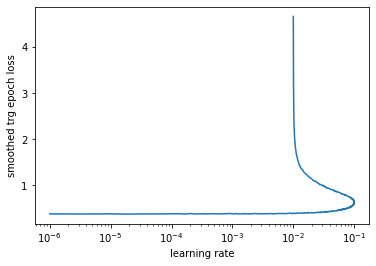

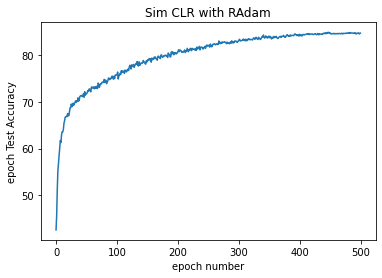

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df=pd.read_csv(csvfilename)

f1=plt.figure()
plt.semilogx(df['lr_epoch'],df['smooth_loss'])  
plt.xlabel('learning rate')
plt.ylabel('smoothed trg epoch loss')
plt.show()

f2=plt.figure()
plt.plot(df['test_acc@1'])
plt.title('Sim CLR with RAdam')
plt.xlabel('epoch number')
plt.ylabel('epoch Test Accuracy')
plt.show()